In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd 

!pip install kaggle

### Load data from Kaggle

In [0]:
!mkdir .kaggle

In [0]:
import json
token = {"username":"insert-user-name","key":"insert-api-token"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

**See some available kaggle datasets by keyword**

In [0]:
!kaggle datasets list -s sentiment


In [11]:
!kaggle datasets download -d  ikarus777/best-artworks-of-all-time -p /content --force

100% 2.16G/2.16G [00:19<00:00, 100MB/s] 
100% 2.16G/2.16G [00:19<00:00, 117MB/s]


In [17]:
!unzip best-artworks-of-all-time.zip

Archive:  best-artworks-of-all-time.zip
replace images.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: images.zip              
  inflating: artists.csv             
  inflating: resized.zip             


### Data exploration

In [0]:
np.random.seed(2)
artistSummary = pd.read_csv('artists.csv')
artistPaintingCounts = artistSummary[['name', 'paintings']].sort_values(by=['paintings'], ascending=False)

In [67]:
artistPaintingCounts.head()

,name,paintings
8,Vincent van Gogh,877
30,Edgar Degas,702
13,Pablo Picasso,439
15,Pierre-Auguste Renoir,336
19,Albrecht Dürer,328


In [0]:
!unzip resized.zip

## Predict painter from image: Model training with Fastai

In [0]:
path_img = '/content/resized'
fnames = get_image_files(path_img)
regex = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, regex, ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

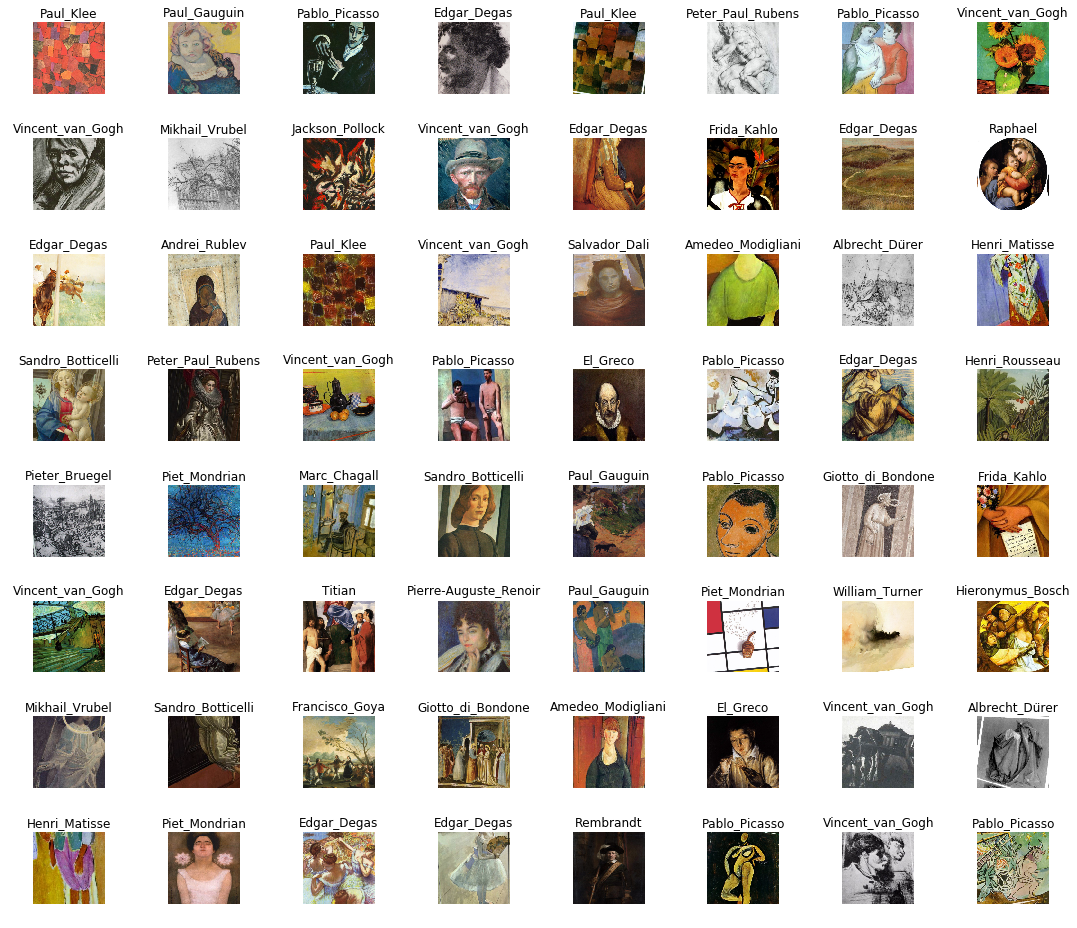

In [22]:
data.show_batch(rows=8, figsize=(15, 13))

In [0]:
data.classes

In [24]:
data.c

50

### **resnet34**

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.model

In [27]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.952962,1.833844,0.490724,05:37
1,1.909688,1.371124,0.372831,05:33
2,1.455031,1.210332,0.331538,05:31
3,1.248022,1.181138,0.318971,05:34


In [0]:
learn.save('stage-1')

### Results & Fine-tuning

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

In [34]:
losses, idxs

(tensor([9.4483e+00, 8.8230e+00, 7.8576e+00,  ..., 7.2193e-04, 6.5327e-04,
         4.1962e-04]), tensor([ 17, 302, 131,  ..., 965, 247, 826]))

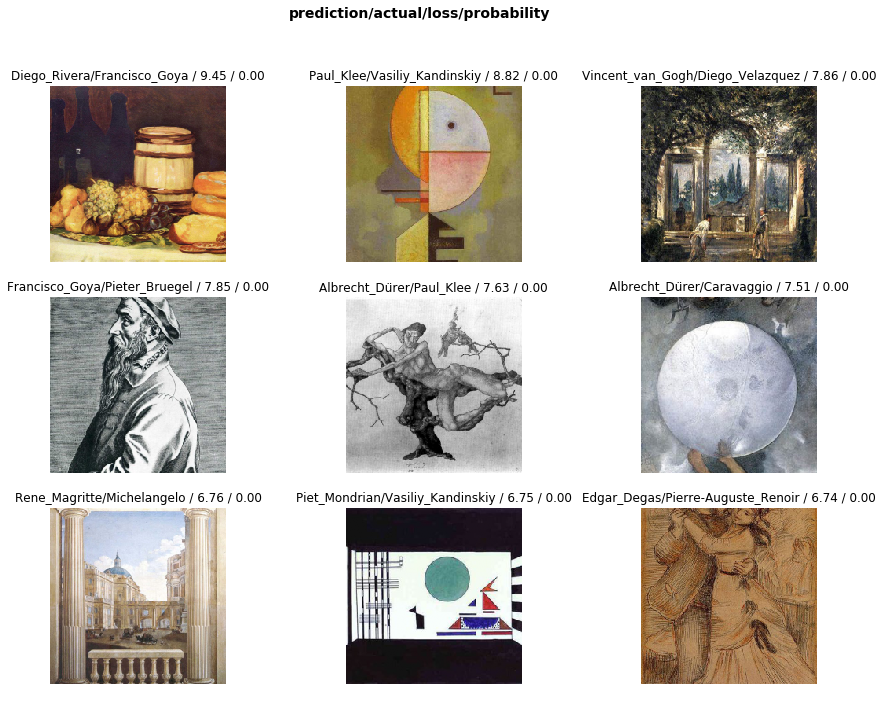

In [35]:
interp.plot_top_losses(9, figsize=(15,11))

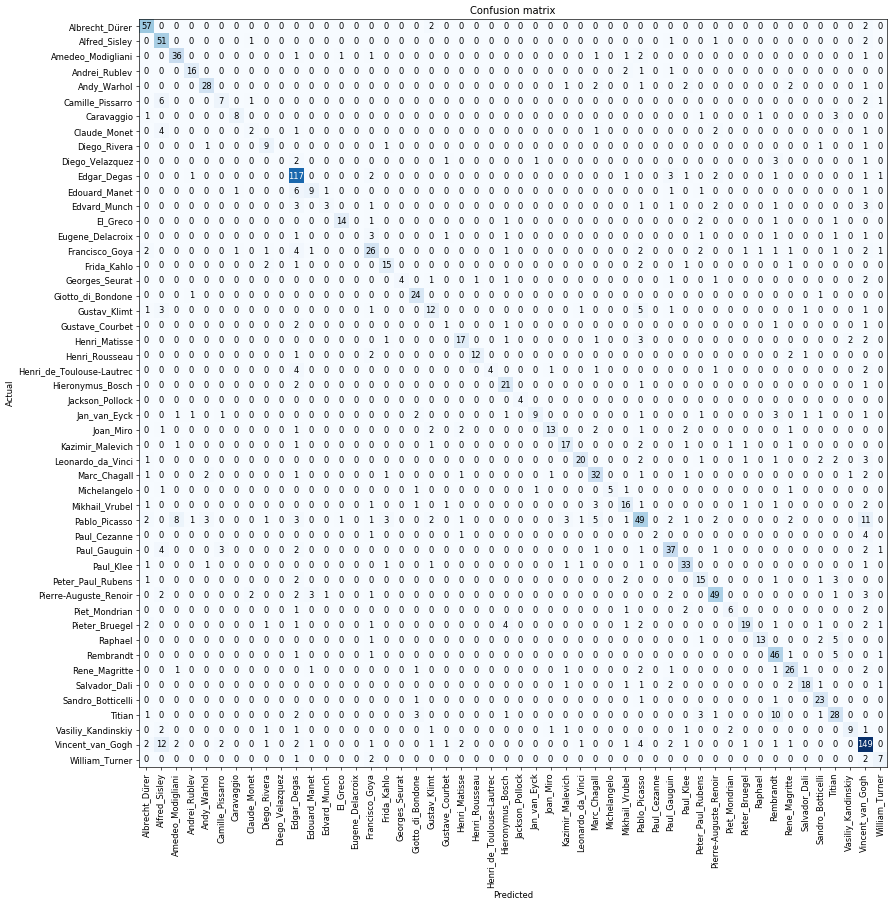

In [36]:
interp.plot_confusion_matrix(figsize=(15, 15), dpi=60)

In [0]:
interp.most_confused(min_val=2)

In [0]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.394965,1.102767,0.318971,05:29


In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


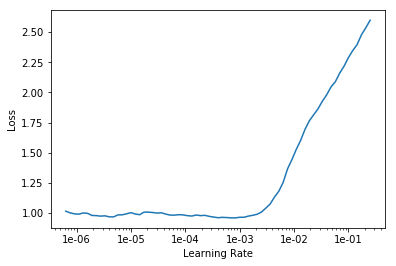

In [41]:
learn.recorder.plot()

In [46]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(1)
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.401581,1.070739,0.304608,02:41


epoch,train_loss,valid_loss,error_rate,time
0,0.916637,0.897684,0.252543,02:34
1,0.756278,0.853616,0.244165,02:33


In [0]:
learn.save('stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()


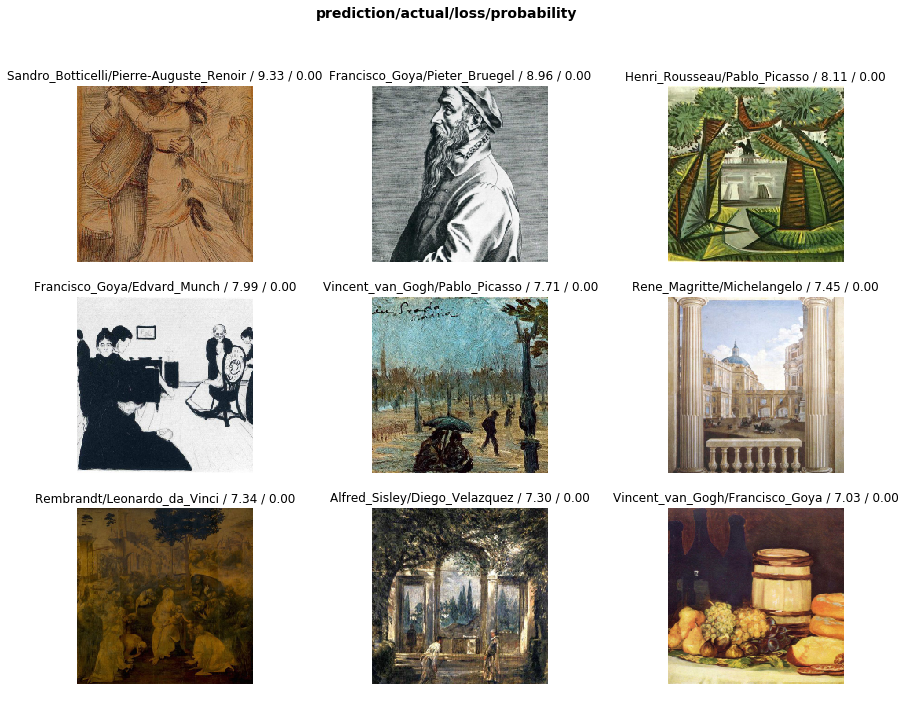

In [49]:
interp.plot_top_losses(9, figsize=(15,11))

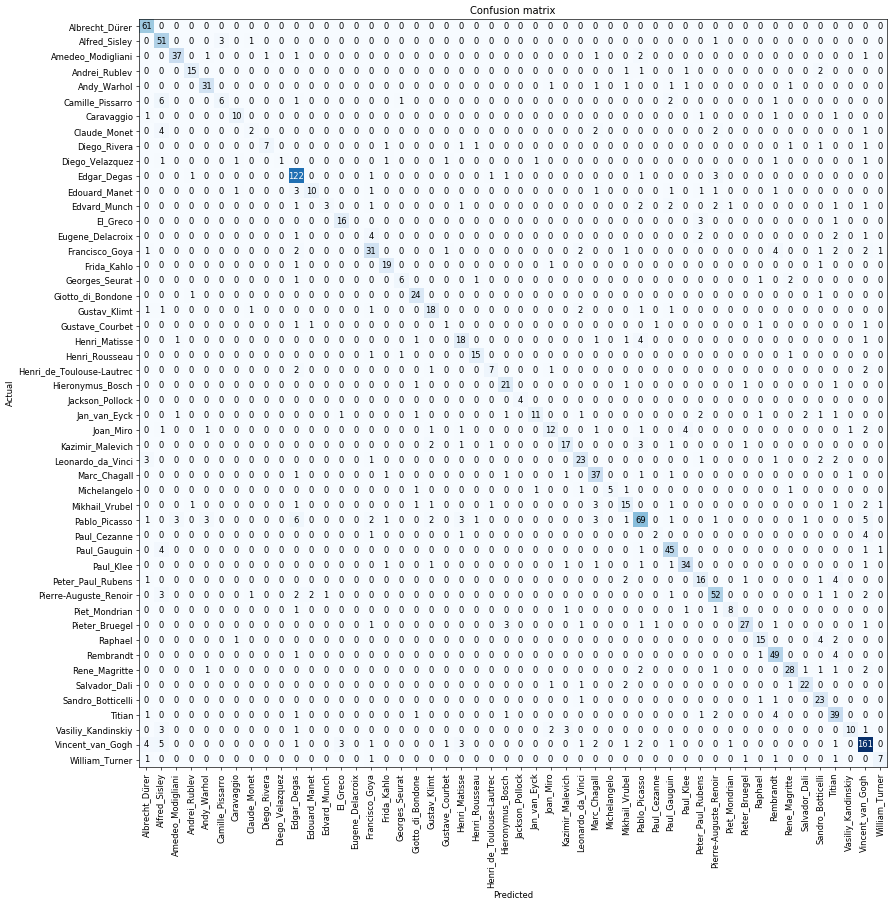

In [50]:
interp.plot_confusion_matrix(figsize=(15,15), dpi=60)

In [52]:
interp.most_confused(min_val=2)

[('Camille_Pissarro', 'Alfred_Sisley', 6),
 ('Pablo_Picasso', 'Edgar_Degas', 6),
 ('Pablo_Picasso', 'Vincent_van_Gogh', 5),
 ('Vincent_van_Gogh', 'Alfred_Sisley', 5),
 ('Claude_Monet', 'Alfred_Sisley', 4),
 ('Eugene_Delacroix', 'Francisco_Goya', 4),
 ('Francisco_Goya', 'Rembrandt', 4),
 ('Henri_Matisse', 'Pablo_Picasso', 4),
 ('Joan_Miro', 'Paul_Klee', 4),
 ('Paul_Cezanne', 'Vincent_van_Gogh', 4),
 ('Paul_Gauguin', 'Alfred_Sisley', 4),
 ('Peter_Paul_Rubens', 'Titian', 4),
 ('Raphael', 'Sandro_Botticelli', 4),
 ('Rembrandt', 'Titian', 4),
 ('Titian', 'Rembrandt', 4),
 ('Vincent_van_Gogh', 'Albrecht_Dürer', 4),
 ('Alfred_Sisley', 'Camille_Pissarro', 3),
 ('Edgar_Degas', 'Pierre-Auguste_Renoir', 3),
 ('Edouard_Manet', 'Edgar_Degas', 3),
 ('El_Greco', 'Peter_Paul_Rubens', 3),
 ('Kazimir_Malevich', 'Pablo_Picasso', 3),
 ('Leonardo_da_Vinci', 'Albrecht_Dürer', 3),
 ('Mikhail_Vrubel', 'Marc_Chagall', 3),
 ('Pablo_Picasso', 'Amedeo_Modigliani', 3),
 ('Pablo_Picasso', 'Andy_Warhol', 3),
 ('Pa

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


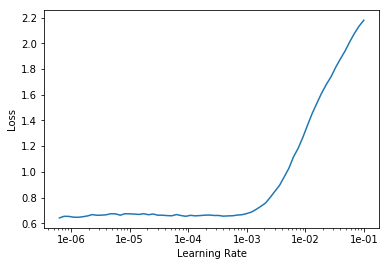

In [54]:
learn.recorder.plot()

In [55]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.659553,0.830221,0.231598,02:42
1,0.621846,0.821948,0.229803,02:36


In [69]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.625717,0.819608,0.233992,02:38
1,0.599439,0.807732,0.225613,02:36
2,0.562181,0.789188,0.221424,02:35
3,0.533386,0.779353,0.215440,02:33
4,0.503923,0.766510,0.211251,02:33
5,0.480522,0.759970,0.209455,02:32
6,0.438969,0.749266,0.208259,02:31
7,0.418660,0.750331,0.208259,02:33
8,0.421378,0.749743,0.207660,02:32
9,0.413077,0.745667,0.206463,02:33


### resnet50

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, regex, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


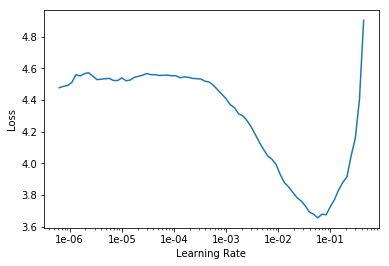

In [80]:
learn.lr_find()
learn.recorder.plot()

In [82]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.329889,1.092116,0.719928,0.280072,03:06
1,1.318832,0.992963,0.732495,0.267504,03:05
2,1.128698,0.852465,0.757630,0.242370,03:03
3,0.913890,0.808973,0.768402,0.231598,03:05
4,0.761550,0.723583,0.799521,0.200479,03:04
5,0.613698,0.677891,0.816278,0.183722,03:04
6,0.520386,0.659463,0.820467,0.179533,03:04
7,0.479711,0.655509,0.818671,0.181329,03:04


In [0]:
learn.save('stage-1-50')

In [85]:
learn.load('stage-1-50')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.435518,0.643416,0.820467,0.179533,03:16
1,0.419485,0.628232,0.827648,0.172352,03:16


In [0]:
learn.save('stage-2-50')